In [1]:
! pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import log_loss, roc_auc_score

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric


import matplotlib.pyplot as plt
import seaborn as sns
import os


from itertools import combinations
import random

from PIL import Image

import catboost as catt


import warnings
warnings.filterwarnings("ignore")
VERSION = 2

In [3]:
import pandas as pd
import numpy as np

# Set base path
base_path = "/kaggle/input/flood-prediction/data/"

# Load datasets
train = pd.read_csv(base_path + "Train.csv")
test = pd.read_csv(base_path + "Test.csv")
submission = pd.read_csv(base_path + "SampleSubmission.csv")
images = np.load(base_path + "composite_images.npz")

# Load train_with_cv_results with debugging
train_with_cv_results = pd.read_csv("/kaggle/input/flood-prediction/test_with_cv_results_accuracy_0_8931.csv")
print("Columns in train_with_cv_results:", train_with_cv_results.columns.tolist())
train_with_cv_results.columns = train_with_cv_results.columns.str.strip()  # Normalize column names
print("Normalized columns:", train_with_cv_results.columns.tolist())

# Select columns
try:
    train_with_cv_results = train_with_cv_results[['location_id', 'predicted_prob']]
    print("Successfully selected columns for train_with_cv_results")
except KeyError as e:
    print(f"KeyError: {e}")

# Load test_with_cv_results with debugging (fixed comma)
test_with_cv_results = pd.read_csv("/kaggle/input/flood-prediction/test_with_cv_results_accuracy_0_8931.csv")
print("Columns in test_with_cv_results:", test_with_cv_results.columns.tolist())
test_with_cv_results.columns = test_with_cv_results.columns.str.strip()
print("Normalized columns:", test_with_cv_results.columns.tolist())

# Select columns
try:
    test_with_cv_results = test_with_cv_results[['location_id', 'predicted_prob']]
    print("Successfully selected columns for test_with_cv_results")
except KeyError as e:
    print(f"KeyError: {e}")

# Display results
display(
    train.head(), train.shape,
    train_with_cv_results.head(), train_with_cv_results.shape,
    test.head(), test.shape
)

Columns in train_with_cv_results: ['location_id', 'event_id_counts', 'image_path', 'predicted_prob', 'predicted_class']
Normalized columns: ['location_id', 'event_id_counts', 'image_path', 'predicted_prob', 'predicted_class']
Successfully selected columns for train_with_cv_results
Columns in test_with_cv_results: ['location_id', 'event_id_counts', 'image_path', 'predicted_prob', 'predicted_class']
Normalized columns: ['location_id', 'event_id_counts', 'image_path', 'predicted_prob', 'predicted_class']
Successfully selected columns for test_with_cv_results


,event_id,precipitation,label
0,id_spictby0jfsb_X_0,0.000000,0
1,id_spictby0jfsb_X_1,0.095438,0
2,id_spictby0jfsb_X_2,1.949560,0
3,id_spictby0jfsb_X_3,3.232160,0
4,id_spictby0jfsb_X_4,0.000000,0


(492020, 3)

,location_id,predicted_prob
0,id_066zz28m11mr,0.000834
1,id_073l04ir88sn,0.998566
2,id_0ajr0br1b046,0.515890
3,id_0mdchsqsdw17,0.999215
4,id_0nu2nus290am,0.860427


(224, 2)

,event_id,precipitation
0,id_j7b6sokflo4k_X_0,0.00000
1,id_j7b6sokflo4k_X_1,3.01864
2,id_j7b6sokflo4k_X_2,0.00000
3,id_j7b6sokflo4k_X_3,16.61520
4,id_j7b6sokflo4k_X_4,2.56706


(163520, 2)

In [4]:
train[train['label']== 1].describe()

,precipitation,label
count,318.000000,318.0
mean,13.801880,1.0
std,18.892779,0.0
min,0.000000,1.0
25%,0.000000,1.0
50%,4.998505,1.0
75%,20.140200,1.0
max,88.336000,1.0


In [5]:
train[train['label']== 0].describe()

,precipitation,label
count,491702.000000,491702.0
mean,1.557776,0.0
std,5.461300,0.0
min,0.000000,0.0
25%,0.000000,0.0
50%,0.000000,0.0
75%,0.000000,0.0
max,277.346000,0.0


In [6]:
def get_location(value):
  return value.split("_")[0] + '_' + value.split("_")[1]

def get_event_id(value):
  return value.split("_")[3]
for df in [train, test]:

  df['location_id'] = df['event_id'].apply(lambda x: '_'.join(x.split('_')[0:2]))
  df['event_idx'] = df.groupby('location_id', sort=False).ngroup()

  df['event_t'] = df.groupby('location_id').cumcount()

print(len(set(train['location_id'])), len(set(test['location_id'])))
print(len(set(train['location_id']).intersection(set(test['location_id']))))
display(train.head(), test.head())

674 224
0


,event_id,precipitation,label,location_id,event_idx,event_t
0,id_spictby0jfsb_X_0,0.000000,0,id_spictby0jfsb,0,0
1,id_spictby0jfsb_X_1,0.095438,0,id_spictby0jfsb,0,1
2,id_spictby0jfsb_X_2,1.949560,0,id_spictby0jfsb,0,2
3,id_spictby0jfsb_X_3,3.232160,0,id_spictby0jfsb,0,3
4,id_spictby0jfsb_X_4,0.000000,0,id_spictby0jfsb,0,4


,event_id,precipitation,location_id,event_idx,event_t
0,id_j7b6sokflo4k_X_0,0.00000,id_j7b6sokflo4k,0,0
1,id_j7b6sokflo4k_X_1,3.01864,id_j7b6sokflo4k,0,1
2,id_j7b6sokflo4k_X_2,0.00000,id_j7b6sokflo4k,0,2
3,id_j7b6sokflo4k_X_3,16.61520,id_j7b6sokflo4k,0,3
4,id_j7b6sokflo4k_X_4,2.56706,id_j7b6sokflo4k,0,4


In [7]:
train.groupby(['location_id'])['event_id'].count()

location_id
id_05v6zjuaf300    730
id_06zma02zeea7    730
id_08w2po0cz63y    730
id_092vetuky9ku    730
id_0987b1h04r48    730
                  ... 
id_zvdfc80cizdl    730
id_zvizc259vrnj    730
id_zw4q7k48qoli    730
id_zyiehp5vejgw    730
id_zyy86zjmrnx2    730
Name: event_id, Length: 674, dtype: int64

* each image has 730 events
* no intersection of images betweeen the two data sets (unique sets)
* The numpy files has 898 images for both train and test

* The images are annual cloud-free composite images from Sentinel-2 satellite imagery. They are of size 128x128 and contain the following 6 channels:

      Sentinel-2 B2 (Blue)
      Sentinel-2 B3 (Green)
      Sentinel-2 B4 (Red)
      Sentinel-2 B8 (NIR)
      Sentinel-2 B11 (SWIR)
      Slope (derived from NASA SRTM)

* the images are essentially static for any event/location pair over the study period.
  * the images only serve as spatial representations of the environment for that location over the 730 day period
  * it reflects static or semi-static environmental conditons (e.g land use, vegetation, water bodies, topography) that could influence flood occurence
  * so the images cannot provide temporal insights but what we can do is extract spatial features such as NDVI, NDWI, NDBI, Topographic features like slope and elevation changes from the slope channel
  * combine the spatial features with temporal precipitation data to enrich the dataset by treating the spatial features as fixed covariates that describe each location.
    * Areas with high NDWI Might flood more frequently with heavy precipitation
    * LOcations with high slope values might experience flash floods after intense rainfall

  * Image processing:
    * Use pretrained models to extract image embeddings or use PCA for dimensionality reduction
    * create a binary classifier where 1 is images where a flood has occured in any of the 730 events and 0 if no floods has occured to create a soft flag for flood-prone locations. Even if not perfect they can serve as a proxy for environmental vulnerability to floods
    * The image classifier naturally reduces the extreme imbalance in the dataset by focusing on binary flood/non-flood classification
  
  * clustering locations:
    * group events/locations based on spatial features (e.g NDVI, NDWI) to identify patterns in flood susceptibility
  * correlating spatial features with precipitation thresholds:
    * study how spatial features interact with specific precipitation thresholds that leads to floods

  * You can think of event_id_X_1 being the 01/01/2024 and event_id_X_2 being 02/01/2024 (dd/mm/yyyy).

### Data Preprocessing + Feature Engineering

In [8]:
train_df = pd.merge(train, train_with_cv_results, on='location_id', how='left')
test_df = pd.merge(test, test_with_cv_results, on='location_id', how='left')


display(train_df.head(), train_df.shape, test_df.head(), test_df.shape)

,event_id,precipitation,label,location_id,event_idx,event_t,predicted_prob
0,id_spictby0jfsb_X_0,0.000000,0,id_spictby0jfsb,0,0,NaN
1,id_spictby0jfsb_X_1,0.095438,0,id_spictby0jfsb,0,1,NaN
2,id_spictby0jfsb_X_2,1.949560,0,id_spictby0jfsb,0,2,NaN
3,id_spictby0jfsb_X_3,3.232160,0,id_spictby0jfsb,0,3,NaN
4,id_spictby0jfsb_X_4,0.000000,0,id_spictby0jfsb,0,4,NaN


(492020, 7)

,event_id,precipitation,location_id,event_idx,event_t,predicted_prob
0,id_j7b6sokflo4k_X_0,0.00000,id_j7b6sokflo4k,0,0,0.999893
1,id_j7b6sokflo4k_X_1,3.01864,id_j7b6sokflo4k,0,1,0.999893
2,id_j7b6sokflo4k_X_2,0.00000,id_j7b6sokflo4k,0,2,0.999893
3,id_j7b6sokflo4k_X_3,16.61520,id_j7b6sokflo4k,0,3,0.999893
4,id_j7b6sokflo4k_X_4,2.56706,id_j7b6sokflo4k,0,4,0.999893


(163520, 6)

In [9]:
selected_columns = []
n_splits = 10
gkf = StratifiedGroupKFold(n_splits = n_splits)

train_df['fold'] = -1
for fold, (_, val_idx) in enumerate(gkf.split(train_df, train_df['label'], groups = train_df['location_id'])):
    train_df.loc[val_idx, "fold"] = fold

train_df['fold'].value_counts()

fold
1    49640
6    49640
0    49640
2    49640
4    48910
5    48910
9    48910
8    48910
7    48910
3    48910
Name: count, dtype: int64

### More Feature Engineering

In [10]:
def get_date_like_features(data):
  data['event_t'] = data['event_t'].astype(int)
  data['event_t_5_window'] = data['event_t'] // 3
  return data

In [11]:
# train_df.groupby(['location_id'])['label'].agg('count')

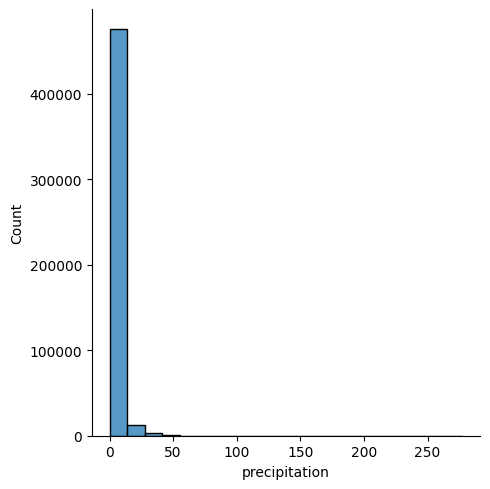

In [12]:
sns.displot((train['precipitation']))

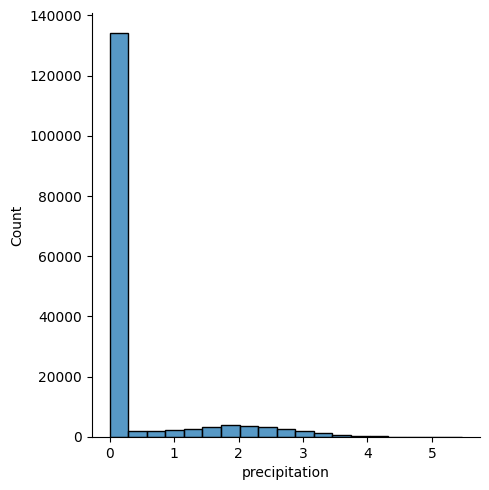

In [13]:
sns.displot(np.log1p(test['precipitation']))

In [14]:
train['event_t'].describe()

count    492020.000000
mean        364.500000
std         210.732865
min           0.000000
25%         182.000000
50%         364.500000
75%         547.000000
max         729.000000
Name: event_t, dtype: float64

In [15]:
train[train['label']==1]['event_t'].describe()

count    318.000000
mean     364.367925
std       40.259331
min      296.000000
25%      328.250000
50%      365.500000
75%      396.000000
max      435.000000
Name: event_t, dtype: float64

In [16]:
train['event_t'].describe()

count    492020.000000
mean        364.500000
std         210.732865
min           0.000000
25%         182.000000
50%         364.500000
75%         547.000000
max         729.000000
Name: event_t, dtype: float64

In [17]:
train[(train['precipitation']==0) & (train['label']==1)]['event_t'].describe()

count    120.000000
mean     364.141667
std       40.033871
min      298.000000
25%      328.750000
50%      365.000000
75%      395.500000
max      435.000000
Name: event_t, dtype: float64

In [18]:
train[(train['precipitation']!=0) & (train['label']==1)]['event_t'].describe()

count    198.000000
mean     364.505051
std       40.496004
min      296.000000
25%      327.500000
50%      366.000000
75%      396.000000
max      435.000000
Name: event_t, dtype: float64

In [19]:
train['location_id'].nunique()

674

In [20]:
from types import new_class
def apply_expanding_combinations(df, group_cols_list, target_col='Sales', shift_periods=[1], min_periods=1, stats=['mean', 'std']):
    # Loop through the group column combinations
    for group_cols in group_cols_list:
        # Generate base name for the grouping
        group_name = '_'.join(group_cols)

        for shift_period in shift_periods:
            for stat in stats:
                expanding_col_name = f'expanding_grouped_{group_name}_{target_col}_shift_{shift_period}_{stat}'

                # Apply groupby, shift, and expanding for the given statistic
                df[expanding_col_name] = df.groupby(group_cols)[target_col].transform(
                    lambda x: x.shift(shift_period).expanding(min_periods=min_periods).agg(stat)
                )

    return df

def smoothen_target(df, group_cols, target_col):
  n_std = 10
  for i_smooth in [target_col]:
      df_id_outlier = df.groupby(group_cols,as_index=False).agg({
          f'{i_smooth}': lambda x: x.mean() + n_std*x.std()
      }).rename(columns={f'{i_smooth}':f'{i_smooth}_outlier'})

      df_id_mean = df.groupby(group_cols,as_index=False).agg({
          f'{i_smooth}': 'mean'
      }).rename(columns={f'{i_smooth}':f'{i_smooth}_mean'})

      df = df.merge(df_id_outlier, on=group_cols[0], how='left')
      df = df.merge(df_id_mean, on=group_cols[0], how='left')

      df[f'{i_smooth}'] = np.where(
          df[f'{i_smooth}'] > df[f'{i_smooth}_outlier'],
          df[f'{i_smooth}_mean'],
          df[f'{i_smooth}']
      )

  return df


def create_rolling_features(data, group_cols, target_col, windows, shift_period, min_period, statistics):
    def apply_statistic(x, stat):
        rolled = x.shift(shift_period).rolling(window=window, min_periods=min_period)
        if stat == 'mean':
            return rolled.mean()
        elif stat == 'median':
            return rolled.median()
        elif stat == 'std':
            return rolled.std()
        elif stat == 'min':
            return rolled.min()
        elif stat == 'max':
            return rolled.max()
        elif stat == 'skew':
            return rolled.skew()
        elif stat == 'sum':
            return rolled.sum()
        elif stat == 'quantile':
            return rolled.quantile(0.95)

        elif stat.startswith('quantile_'):
            q = float(stat.split('_')[1])
            return rolled.quantile(q)
        else:
            raise ValueError(f"Unknown statistic: {stat}")

    for window in windows:
        for stat in statistics:
            stat_name = stat if not stat.startswith('quantile_') else f"{stat.split('_')[1]}th"
            col_name = f'rolling_previous_grouped_{target_col}_{stat_name}_{window}_{shift_period}'

            data[col_name] = data.groupby(group_cols)[target_col].transform(
                lambda x: apply_statistic(x, stat)
            )

    return data



def custom_agg(x):
    return x.max() - x.min()

def get_date_features(df):
  # Simulate year (assuming 365 days per year)
  df['year'] = (df['event_t'] // 365) + 1  # Year 1 or 2

  # Simulate month (approximate)
  df['month'] = ((df['event_t'] % 365) // 30) + 1  # 30-day months approximation

  # Simulate week of the year
  df['week_of_year'] = (df['event_t'] % 365) // 7 + 1

  # Simulate day of the month
  df['day_of_month'] = (df['event_t'] % 30) + 1  # Assuming 30-day months

  # Simulate day of the week (0 = Monday, 6 = Sunday)
  df['day_of_week'] = df['event_t'] % 7

  # Simulate quarter
  df['quarter'] = ((df['month'] - 1) // 3) + 1
  return  df




def feature_engineering(train, test):
  data = pd.concat([train, test])
  data.sort_values(by = ['location_id', 'event_t'], inplace=True)
  data['event_t'] = data['event_t'].astype(int)
  # data = smoothen_target(data, ['location_id'], 'precipitation')

  data['event_binary'] = data['event_t'].apply(lambda x: 1 if (x >= 296 and x <= 435) else 0)


  group_cols =['location_id']
  # data = apply_expanding_combinations(
  #     data,
  #     [group_cols],
  #     target_col='precipitation',
  #     shift_periods=[1],#1,3, 4, 5, 6, 7, 8, 24
  #     min_periods=1,
  #     stats=['mean']
  # )

  statistics = ['mean'] #, 'median', 'std', 'quantile_0.25', 'quantile_0.75'
  min_period = 1

  shift_period = 0
  windows = [3, 4,10,20, 25, 30,55,60, 75, 296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 2
  # windows = [3, 4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 3
  # windows = [3, 4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 4
  # windows = [3, 4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 5
  # windows = [3, 4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 6
  # windows = [ 3,4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)

  # shift_period = 8
  # windows = [ 3,4,10,20, 25, 30,55,60, 75,296]#3, 4, 10, 20,25,30, 50, 55, 60, 75,
  # data = create_rolling_features(data, group_cols,'precipitation', windows, shift_period, min_period, statistics)
  # # data = get_date_features(data)

  for col in ['precipitation']:
    # data[f"grouped_location_{col}_cum"] = data.groupby('location_id')[col].cumsum().shift(1)

    # quantile = 0.95  # Define the quantile you want to calculate
    # for stat in ['mean', 'quantile']:
    #     if stat != 'quantile':
    #         data[f"location_grouped_{col}_{stat}"] = data.groupby('location_id')[col].transform(stat)
    #         data[f"diff_{col}_{stat}"] = data[col] - data[f"location_grouped_{col}_{stat}"]


    for shift in range(1,365):
      data[f'{col}_shift_{shift}'] = data.groupby('location_id')[col].shift(shift)
      data[f'{col}_next_shift_{shift}'] = data.groupby('location_id')[col].shift(-shift)




    # for window in windows:
    #   data[f'{col}_rolling_grouped_custom_{window}'] = (
    #       data.groupby('location_id')[col]
    #       .rolling(window)
    #       .apply(custom_agg)
    #       .reset_index(level=0, drop=True)  # Reset the index to align with the original DataFrame
    #   )

    for span in [7]:
        data[f'{col}_ewm_grouped_mean_{span}'] = (
            data.groupby('location_id')[col]
            .ewm(span=span, adjust=False)
            .mean()
            .reset_index(level=0, drop=True)  # Reset the index to align it with the original DataFrame
        )




  train = data[data['label'].notna()].reset_index(drop = True)
  test = data[data['label'].isna()].reset_index(drop = True)

  return train, test

new_train, new_test = feature_engineering(train_df, test_df)
display(new_train.head(), new_train.shape, new_test.head(), new_test.shape)

,event_id,precipitation,label,location_id,event_idx,event_t,predicted_prob,fold,event_binary,rolling_previous_grouped_precipitation_mean_3_0,...,precipitation_next_shift_360,precipitation_shift_361,precipitation_next_shift_361,precipitation_shift_362,precipitation_next_shift_362,precipitation_shift_363,precipitation_next_shift_363,precipitation_shift_364,precipitation_next_shift_364,precipitation_ewm_grouped_mean_7
0,id_05v6zjuaf300_X_0,0.00000,0.0,id_05v6zjuaf300,435,0,NaN,4.0,0,0.000000,...,0.00000,NaN,0.00000,NaN,0.00000,NaN,0.00000,NaN,6.01065,0.000000
1,id_05v6zjuaf300_X_1,9.45176,0.0,id_05v6zjuaf300,435,1,NaN,4.0,0,4.725880,...,0.00000,NaN,0.00000,NaN,0.00000,NaN,6.01065,NaN,24.95070,2.362940
2,id_05v6zjuaf300_X_2,0.00000,0.0,id_05v6zjuaf300,435,2,NaN,4.0,0,3.150587,...,0.00000,NaN,0.00000,NaN,6.01065,NaN,24.95070,NaN,0.00000,1.772205
3,id_05v6zjuaf300_X_3,0.00000,0.0,id_05v6zjuaf300,435,3,NaN,4.0,0,3.150587,...,0.00000,NaN,6.01065,NaN,24.95070,NaN,0.00000,NaN,0.00000,1.329154
4,id_05v6zjuaf300_X_4,0.00000,0.0,id_05v6zjuaf300,435,4,NaN,4.0,0,0.000000,...,6.01065,NaN,24.95070,NaN,0.00000,NaN,0.00000,NaN,0.00000,0.996865


(492020, 748)

,event_id,precipitation,label,location_id,event_idx,event_t,predicted_prob,fold,event_binary,rolling_previous_grouped_precipitation_mean_3_0,...,precipitation_next_shift_360,precipitation_shift_361,precipitation_next_shift_361,precipitation_shift_362,precipitation_next_shift_362,precipitation_shift_363,precipitation_next_shift_363,precipitation_shift_364,precipitation_next_shift_364,precipitation_ewm_grouped_mean_7
0,id_066zz28m11mr_X_0,0.0,NaN,id_066zz28m11mr,118,0,0.000834,NaN,0,0.0,...,0.605245,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0
1,id_066zz28m11mr_X_1,0.0,NaN,id_066zz28m11mr,118,1,0.000834,NaN,0,0.0,...,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0
2,id_066zz28m11mr_X_2,0.0,NaN,id_066zz28m11mr,118,2,0.000834,NaN,0,0.0,...,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0
3,id_066zz28m11mr_X_3,0.0,NaN,id_066zz28m11mr,118,3,0.000834,NaN,0,0.0,...,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0
4,id_066zz28m11mr_X_4,0.0,NaN,id_066zz28m11mr,118,4,0.000834,NaN,0,0.0,...,0.000000,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0


(163520, 748)

<Axes: xlabel='precipitation', ylabel='Density'>

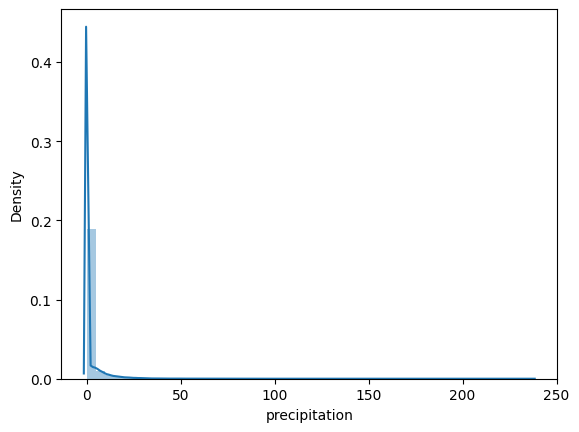

In [21]:
sns.distplot(new_test['precipitation'])

### MODELLING
674 224

In [22]:
new_train['label'].value_counts()

label
0.0    491702
1.0       318
Name: count, dtype: int64

In [23]:
for i in range(n_splits):
  print(new_train[new_train['fold'] == i]['label'].value_counts())
  print("-"* 100)

label
0.0    49608
1.0       32
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    49608
1.0       32
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    49608
1.0       32
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    48879
1.0       31
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    48878
1.0       32
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    48879
1.0       31
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
label
0.0    49608
1.0       32
Name: count, d

### MODELLING

In [24]:
new_test.isnull().sum()

event_id                                 0
precipitation                            0
label                               163520
location_id                              0
event_idx                                0
                                     ...  
precipitation_shift_363              81312
precipitation_next_shift_363         81312
precipitation_shift_364              81536
precipitation_next_shift_364         81536
precipitation_ewm_grouped_mean_7         0
Length: 748, dtype: int64

In [25]:

indices_cols = [
  'EVI_mean',
 'EVI_median',
 'EVI_std',
 'MNDWI_mean',
 'MNDWI_median',
 'MNDWI_std',
 'MSI_mean',
 'MSI_median',
 'MSI_std',
 'NDVI_mean',
 'NDVI_median',
 'NDVI_std',
 'NDWI_mean',
 'NDWI_median',
 'NDWI_std',
 'Slope_mean',
 'Slope_median',
 'Slope_std',
]

selected_columns =['precipitation','predicted_prob','event_binary', 'event_t'] + [col for col in new_train if 'diff' in col or 'shift' in col or 'grouped' in col ]

print(selected_columns)
target_col = 'label'

['precipitation', 'flood_probability', 'event_binary', 'event_t', 'rolling_previous_grouped_precipitation_mean_3_0', 'rolling_previous_grouped_precipitation_mean_4_0', 'rolling_previous_grouped_precipitation_mean_10_0', 'rolling_previous_grouped_precipitation_mean_20_0', 'rolling_previous_grouped_precipitation_mean_25_0', 'rolling_previous_grouped_precipitation_mean_30_0', 'rolling_previous_grouped_precipitation_mean_55_0', 'rolling_previous_grouped_precipitation_mean_60_0', 'rolling_previous_grouped_precipitation_mean_75_0', 'rolling_previous_grouped_precipitation_mean_296_0', 'precipitation_shift_1', 'precipitation_next_shift_1', 'precipitation_shift_2', 'precipitation_next_shift_2', 'precipitation_shift_3', 'precipitation_next_shift_3', 'precipitation_shift_4', 'precipitation_next_shift_4', 'precipitation_shift_5', 'precipitation_next_shift_5', 'precipitation_shift_6', 'precipitation_next_shift_6', 'precipitation_shift_7', 'precipitation_next_shift_7', 'precipitation_shift_8', 'prec

In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from scipy.stats import hmean, gmean

test_preds_list = []  # Store fold-wise test predictions
loglosses = []
oof = []

new_train = new_train.fillna(0)
new_train[selected_columns] = new_train[selected_columns].astype(np.float32)

new_test = new_test.fillna(0)
new_test[selected_columns] = new_test[selected_columns].astype(np.float32)

# K-Fold Training
for fold in range(n_splits):
    print(f"============================= TRAINING FOLD: {fold+1} ================================")

    training = new_train[new_train['fold'] != fold]
    validation = new_train[new_train['fold'] == fold]


    y_train = training[target_col]
    y_test = validation[target_col]
    X_train = training[selected_columns]
    X_test = validation[selected_columns]


    # Train the TabNet model
    model = TabNetClassifier(n_d = 35, # Width of the decision prediction layer
                                n_a = 35, # Width of the attention embedding for each mask
                                n_steps = 2, # Number of steps in the architecture
                                gamma = 1.3, # coefficient for feature reusage in the masks
                                n_independent = 1, # Number of independent Gated Linear Units layers at each step
                                n_shared = 2, # Number of shared Gated Linear Units at each step
                                momentum = 0.02, # Momentum for batch normalization
                                clip_value = None, # extra sparsity loss coefficient
                                lambda_sparse = 1e-3,
                                optimizer_fn = torch.optim.AdamW, # Adam optimizer
                                optimizer_params = dict(lr = 2e-2, weight_decay=0.01), # Optimizer params
                                scheduler_fn = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
                                scheduler_params = {'T_0':5,
                                                    'eta_min':1e-3,
                                                    'T_mult':1,
                                                    'last_epoch':-1},
                                mask_type = 'entmax', # masking function to use for selecting features
                                device_name='cuda', # Run on gpu
                                seed = 2025)

    model.fit(X_train.values, y_train.values.ravel(), eval_set = [(X_test.values, y_test.values.ravel())],
                  max_epochs = 40,
                  patience = 40,
                  virtual_batch_size = 256,
                  batch_size = 4096,
                  eval_metric=['logloss'])

    # Store out-of-fold predictions
    oof_preds = model.predict_proba(X_test.values)[:, 1]

    # Calculate logloss
    loss = log_loss(y_test, oof_preds)
    print(f"Logloss: {loss}")
    print("*" * 100)
    loglosses.append(loss)

    # Inference on the test set
    fold_preds = model.predict_proba(new_test[selected_columns].values)[:, 1]
    test_preds_list.append(fold_preds)  # Store for alternative means

    df = new_train.loc[validation.index.values, ['event_id', 'location_id', 'predicted_prob', 'event_t', 'label']].copy()
    df['oof_tabnet_pred'] = oof_preds
    oof.append(df)


# Compute final scores
# new_train['oof_correct_prob'] = oof_preds
oof = pd.concat(oof, axis=0, ignore_index=True)
oof.to_csv(f'tabnet_oof_koleshjr_version{VERSION}.csv', index=False)
print(f"Mean logloss: {np.mean(loglosses)}")
print(f"OOF logloss: {log_loss(oof['label'], oof['oof_tabnet_pred'])}")
print(f"OOF roc_auc: {roc_auc_score(oof['label'], oof['oof_tabnet_pred'])}")

# Convert list of fold predictions to NumPy array (shape: n_splits x n_samples)
fold_preds_array = np.array(test_preds_list)

# Compute different mean types
avg_preds_arith = fold_preds_array.mean(axis=0)  # Arithmetic mean




# Save different mean-based submissions
submission = new_test[['event_id']].copy()
submission['tabnet_preds'] = avg_preds_arith
submission.to_csv(f'tabnet_version{VERSION}.csv', index=False)

KeyError: "['flood_probability'] not in index"

### Normalizing the Probabilities based on the Flood Probability

In [ ]:
from sklearn.metrics import log_loss

print(f"logloss before normalizing: {log_loss(oof['label'], oof['oof_tabnet_pred'])}")

locations_to_normalize = oof[oof['predicted_prob'] >= 0.5]['location_id'].unique()
oof['oof_sum_prob'] = oof.groupby('location_id')['oof_tabnet_pred'].transform('sum')

# Avoid division by zero
epsilon = 1e-8
oof['oof_tabnet_norm'] = oof['oof_tabnet_pred']  # Copy original values

oof.loc[oof['location_id'].isin(locations_to_normalize), 'oof_tabnet_norm'] = (
    oof.loc[oof['location_id'].isin(locations_to_normalize), 'oof_tabnet_pred'] /
    (oof.loc[oof['location_id'].isin(locations_to_normalize), 'oof_sum_prob'] + epsilon)
)

print(f"logloss after normalizing: {log_loss(oof['label'], oof['oof_tabnet_norm'])}")